In [9]:
!pip install kmodes
import numpy as np # linear algebra
import pandas as pd
import numpy as np
import pandas as pd
import datetime
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns
from kmodes.kmodes import KModes
import warnings
np.random.seed(42)

In [35]:
!pip install Yellowbrick

  Using cached yellowbrick-1.3.post1-py3-none-any.whl (271 kB)


In [2]:
profile = pd.read_csv('profile_dev.csv')
major = pd.read_csv('major.csv')
major_profiles = pd.read_csv('major_profiles.csv')
certification = pd.read_csv('certification.csv')
certification_profiles = pd.read_csv('certification_profiles.csv')
companies = pd.read_csv('companies.csv')
company_description = pd.read_csv('company_description.csv')
language = pd.read_csv('language.csv')
language_profiles = pd.read_csv('language_profiles.csv')
linkedin = pd.read_csv('linkedin.csv')
linkedin_users = pd.read_csv('linkedin_users.csv')
skills = pd.read_csv('skills.csv')
skills_profiles = pd.read_csv('skills_profiles.csv')



In [5]:
profile.head()

,profile_ID,user_ID,company_ID,title,date,modified,city,state,country,teaching
0,79,13455,1,Unknown,2021-10-17 15:12,2021-10-17 15:12,San Mateo,California,United States of America,False
1,68,16896,223,Division Director,2021-10-17 13:51,2021-10-17 13:51,日本 東京,Unknown,Japan,False
2,44,37899,224,Data Analytics Engineer,2021-10-17 15:12,2021-10-17 15:12,San Jose,California,United States of America,True
3,30,12448,9,"Advisory Associate, Digital Lighthouse",2021-10-17 15:12,2021-10-17 15:12,Ann Arbor,Michigan,United States of America,True
4,76,15158,1,Unknown,2021-10-17 15:12,2021-10-17 15:12,Windsor Mill,Maryland,United States of America,False


In [14]:
data = profile.merge(skills_profiles).merge(skills).fillna('Unknown').drop(columns=['skills_profiles_ID','skill_ID'])\
                                                        .merge(language_profiles).merge(language).fillna('Unknown').drop(columns=['language_profiles_ID','language_ID'])\
                                                        .merge(major_profiles).merge(major).fillna('Unknown').drop(columns=['major_profiles_ID','major_ID'])\
                                                        .merge(certification_profiles).merge(certification).fillna('Unknown').drop(columns=['certification_profiles_ID','certification_ID'])\
                                                        .merge(companies).fillna('Unknown').drop(columns=['company_ID','website','user_ID','company_name','website'])

In [3]:
data = pd.read_csv('cluster_data.csv')

In [4]:
data = data.set_index('profile_ID').drop_duplicates()
## certification_name is overlap with skill
data = data.drop(columns='certification_name').drop_duplicates()
data.head()

,title,city,country,teaching,skill_name,language_name,major_name,industry
profile_ID,,,,,,,,
25064,Analytics Manager,Bangalore Urban,India,False,python,English,Data Science,Information Technology & Services
25064,Analytics Manager,Bangalore Urban,India,False,tableau,English,Data Science,Information Technology & Services
25064,Analytics Manager,Bangalore Urban,India,False,sql,English,Data Science,Information Technology & Services
25064,Analytics Manager,Bangalore Urban,India,False,python,English,General,Information Technology & Services
25064,Analytics Manager,Bangalore Urban,India,False,tableau,English,General,Information Technology & Services


In [5]:
data['title'].value_counts()

Data Scientist                                                      6350
Senior Data Scientist                                               2543
Technical PM Machine  Intelligence                                  2142
Senior Data Engineer                                                1745
Data Engineer                                                       1659
                                                                    ... 
Branch Chief, Emerging Technology and Design Acceleration Branch       1
Senior Java Developer                                                  1
Data Analytics Manager                                                 1
Global Data Science                                                    1
Senior Manager, Ignition - Data & Analytics                            1
Name: title, Length: 954, dtype: int64

In [16]:
data = data[data['industry']!='Unknown'].set_index('profile_ID')
data

,title,city,country,teaching,skill_name,language_name,major_name,certification_name,industry
profile_ID,,,,,,,,,
25064,Analytics Manager,Bangalore Urban,India,False,python,English,Data Science,Tableau Desktop Specialist,Information Technology & Services
25064,Analytics Manager,Bangalore Urban,India,False,tableau,English,Data Science,Tableau Desktop Specialist,Information Technology & Services
25064,Analytics Manager,Bangalore Urban,India,False,sql,English,Data Science,Tableau Desktop Specialist,Information Technology & Services
25064,Analytics Manager,Bangalore Urban,India,False,python,English,General,Tableau Desktop Specialist,Information Technology & Services
25064,Analytics Manager,Bangalore Urban,India,False,tableau,English,General,Tableau Desktop Specialist,Information Technology & Services
...,...,...,...,...,...,...,...,...,...
2172,Category Administrator - Ecommerce Merchandising,Toronto,Canada,False,sql,Hindi,Condensed Matter and Materials Physics,Advanced MS Excel,Retail
2172,Category Administrator - Ecommerce Merchandising,Toronto,Canada,False,sql,Malayalam,Condensed Matter and Materials Physics,Advanced MS Excel,Retail
2172,Category Administrator - Ecommerce Merchandising,Toronto,Canada,False,sql,English,Urban + Regional Planning,Advanced MS Excel,Retail


In [6]:
import re
# Put all Lead related titles into the Lead category
d0 = data['title'].mask((data['title'].str.contains('Lead|Specialist',case=False,regex=True)),'Specialist')
# Put all management related titles into the Manager category
d1 = d0.mask(d0.str.contains('Manager|CEO|Director|President|Chair|PM|Chief|VP',case=False,regex=True),'Manager')
# Put all data science related titles into the Data Scientist category
d2 = d1.mask((d1.str.contains('Data Scientist',case=False)),'Data Scientist')
d3 = d2.mask((d2.str.contains('Data Science',case=False)),'Data Scientist')
# Put all Data Engineer related titles into the Data Engineer category
d4 = d3.mask((d3.str.contains('Data Engineer',case=False)),'Data Engineer')
# Put all Human Resource related titles into the Human Resource category
d5 = d4.mask((d4.str.contains('HR')) | (d4.str.contains('Human Resource',case=False)),'Human Resource')
# Put all Machine Learning related titles into the Machine Learning category
d6 = d5.mask((d5.str.contains('Machine Learning',case=False)),'Machine Learning')
# Put all Data Analyst related titles into the Data Analyst category
d7 = d6.mask((d6.str.contains('Data Analyst',case=False)),'Data Analyst')
# Put all Software Engineer related titles into the Software Engineer category
d8 = d7.mask((d7.str.contains('Software',case=False))| (d7.str.contains('Digital',case=False)),'Software')
# Put all  Engineer related titles into the non Data Engineer category
d9 = d8.mask(d8.str.contains('[^D][^a][^t][^a] Engineer',case=False,regex=True),'non-Data Engineer')
# Put all  Data Achitect titles into the Data Architect category
d10 = d9.mask((d9.str.contains('Architect',case=False)),'Data Architect')
# Put all  Analyst titles into the non-Data Analyst category
d11 = d10.mask((d10.str.contains('[^D][^a][^t][^a] Analyst',case=False,regex=True)),'non-Data Analyst')
# Put all  Data Consultant titles into the Data Consultant category
d12 = d11.mask((d11.str.contains('Data Consultant',case=False)),'Data Consultant')
# Put all  non-Data Consultant titles into the non-Data Consultant category
d13 = d12.mask((d12.str.contains('[^D][^a][^t][^a] Consultant',case=False,regex=True)),'non-Data Consultant')
# Put all  Advisor titles into the Advisor Consultant category
d14 = d13.mask((d13.str.contains('Advisor',case=False)),'Advisor')
# Put all  Developer titles into the Developer category
d15 = d14.mask((d14.str.contains('Developer',case=False)),'Developer')
# Put all  Sales titles into the Sales category
d16 = d15.mask((d15.str.contains('Sale',case=False)),'Sales')
# Put all  Media titles into the Media category
d17 = d16.mask((d16.str.contains('Media',case=False))|(d16.str.contains('Reporter')),'Media')
# Put all  Administrator titles into the Administrator category
d18 = d17.mask((d17.str.contains('Administrator',case=False)),'Administrator')
# Put all  Associate titles into the Administrator category
d19 = d18.mask((d18.str.contains('Associate',case=False)),'Associate')
# Put all  Consultant titles into the Consultant category
d20 = d19.mask((d19.str.contains('Research|Researcher',case=False,regex=True)),'Researcher')
d21 = d20.where((d20.str.contains('Specialist|Researcher|Machine Learning|Manager|Data Engineer|Data Scientist|Human Resource|Associate|Administrator|Media|Sales|Developer|Advisor|non-Data Consultant|Data Consultant|non-Data Analyst|Data Architect|non-Data Engineer|Software|Data Analyst',case=False,regex=True)),'Others')
d21.value_counts()

Data Scientist         17909
Manager                11246
Data Engineer           6000
Specialist              4771
Others                  4197
Software                3372
Data Analyst            2864
non-Data Analyst        1728
non-Data Engineer       1723
Data Architect          1428
Associate                787
Developer                503
non-Data Consultant      317
Machine Learning         302
Advisor                  282
Media                    271
Researcher               153
Data Consultant          150
Administrator             51
Human Resource            37
Sales                      2
Name: title, dtype: int64

In [12]:
data['job type'] = d21
data = data.drop(columns=['title'])

KeyError: "['title'] not found in axis"

In [13]:
data = data.drop(columns=['city'])

In [15]:
data.head()

,country,teaching,skill_name,language_name,major_name,industry,job type
profile_ID,,,,,,,
25064,India,False,python,English,Data Science,Information Technology & Services,Manager
25064,India,False,tableau,English,Data Science,Information Technology & Services,Manager
25064,India,False,sql,English,Data Science,Information Technology & Services,Manager
25064,India,False,python,English,General,Information Technology & Services,Manager
25064,India,False,tableau,English,General,Information Technology & Services,Manager


Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 0, cost: 281911.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 0, cost: 281911.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 3, iteration: 1/100, moves: 0, cost: 281911.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 4, iteration: 1/100, moves: 0, cost: 281911.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 5, iteration: 1/100, moves: 0, cost: 281911.0
Best run was number 1
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 2992, cost: 270504.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 10317, cost: 257981.0
Run 2, iteration: 2/100, moves: 3073, cost: 257981.0
Init: in

Starting iterations...
Run 5, iteration: 1/100, moves: 16869, cost: 220110.0
Run 5, iteration: 2/100, moves: 1307, cost: 220110.0
Best run was number 1


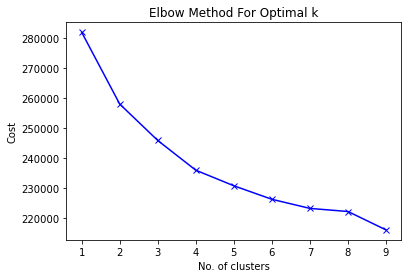

In [16]:
# Elbow curve to find optimal number of clusters
cost = []
K = range(1,10)
for num_clusters in list(K):
    kmode = KModes(n_clusters=num_clusters, init = "random", n_init = 5, verbose=-1)
    kmode.fit_predict(data)
    cost.append(kmode.cost_)
    
plt.plot(K, cost, 'bx-')
plt.xlabel('No. of clusters')
plt.ylabel('Cost')
plt.title('Elbow Method For Optimal k')
plt.show()

In [17]:
#The elbow plot shows that the ideal number of clusters is 6, set n_clusters as 6
kmode = KModes(n_clusters=6, init = "random", n_init = 6, verbose=2)
clusters = kmode.fit_predict(data)
data.insert(0, "Cluster", clusters, True)
data

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 14764, cost: 233106.0
Run 1, iteration: 2/100, moves: 2, cost: 233106.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 21764, cost: 232820.0
Run 2, iteration: 2/100, moves: 1197, cost: 232820.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 3, iteration: 1/100, moves: 16548, cost: 232963.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 4, iteration: 1/100, moves: 12704, cost: 234604.0
Run 4, iteration: 2/100, moves: 22, cost: 234604.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 5, iteration: 1/100, moves: 28505, cost: 232040.0
Run 5, iteration: 2/100, moves: 1913, cost: 232040.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 6, iteration: 1/100, moves: 11545, cost

,Cluster,country,teaching,skill_name,language_name,major_name,industry,job type
profile_ID,,,,,,,,
25064,2,India,False,python,English,Data Science,Information Technology & Services,Manager
25064,2,India,False,tableau,English,Data Science,Information Technology & Services,Manager
25064,1,India,False,sql,English,Data Science,Information Technology & Services,Manager
25064,4,India,False,python,English,General,Information Technology & Services,Manager
25064,4,India,False,tableau,English,General,Information Technology & Services,Manager
...,...,...,...,...,...,...,...,...
2172,1,Canada,False,sql,Hindi,Condensed Matter and Materials Physics,Retail,Administrator
2172,1,Canada,False,sql,Malayalam,Condensed Matter and Materials Physics,Retail,Administrator
2172,4,Canada,False,sql,English,Urban + Regional Planning,Retail,Administrator


In [18]:
# summarize the major clusters
count = data['Cluster'].value_counts()
centroids = kmode.cluster_centroids_
cluster_label = pd.DataFrame(centroids,columns = ['country','teaching','skill','language','major','industry','job type'])
cluster_label['number_records'] = count
cluster_label
## the output is not shown due to business concerns

,country,teaching,skill,language,major,industry,job type,number_records
0,United States of America,False,python,Hindi,Computer Science,Internet,Manager,18604
1,India,False,sql,Hindi,Computer Science,Hospital & Health Care,Data Scientist,9287
2,United States of America,False,python,English,Computer Science,Information Technology & Services,Data Scientist,12254
3,United States of America,True,python,English,Computer Science,Hospital & Health Care,Data Scientist,12381
4,Canada,False,python,English,General,Information Technology & Services,Data Scientist,2487
5,India,False,python,English,Computer Science,Retail,non-Data Engineer,3080
